# Ranet on TF2 keras
## Running Cifar10
### Implementation by: Max Midwinter
### Mark 1

#### Import Dependencies

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import Lambda, ReLU, Input, UpSampling2D
from tensorflow.keras.models import Model
%matplotlib inline
tf.version

<module 'tensorflow._api.v2.version' from '/home/cviss3/.conda/envs/py3k/envs/syde671/lib/python3.7/site-packages/tensorflow/_api/v2/version/__init__.py'>

#### Loading the Cifar10 dataset
#### Normalize images

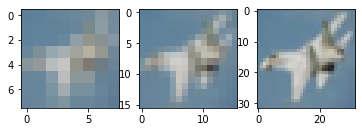

In [3]:
#Setting class names for the dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Loading the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# large data
X_train_large = X_train
X_test_large = X_test

# medium data
X_train_med = tf.image.resize_with_pad(X_train, 16, 16, antialias=True)
X_test_med = tf.image.resize_with_pad(X_test, 16, 16, antialias=True)

# small data
X_train_small = tf.image.resize_with_pad(X_train, 8, 8, antialias=True)
X_test_small = tf.image.resize_with_pad(X_test, 8, 8, antialias=True)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(X_test_small[10])
axes[1].imshow(X_test_med[10])
axes[2].imshow(X_test_large[10])

#https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

#### Define Small Models

In [4]:
# Ranet Hyperparams
batch_size = 64
momentum = 0.9
decay = 1e-4
learning_rate = 0.1  #0.01 after epoch 150 0.001 after epoch 225
epochs = 300

small_model = tf.keras.models.Sequential()

# Define Small Model
small_model.add(Input(shape=(8, 8, 3)))
#small_model.add(Lambda(augment_2d, input_shape=X_train_small.shape[1:], arguments={'rotation':0, 'horizontal_flip':True}, name="data_aug"))
# First Conv Block (cuz cifar no maxpool)
small_model.add(Conv2D(filters=64, kernel_size=3, strides=1,padding='same', activation=None, name="small_conv1"))
small_model.add(BatchNormalization(name="small_bn1"))
small_model.add(ReLU(name="small_relu1"))

# Second Conv Block
small_model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation=None, name="small_conv2"))
small_model.add((BatchNormalization(name="small_bn2")))
small_model.add(ReLU(name="small_relu2"))

# Classification
small_model.add(Conv2D(filters=128, kernel_size=3, strides=2, padding='same'))
small_model.add(Conv2D(filters=128, kernel_size=3, strides=2, padding='same'))
small_model.add(Flatten(name='flatten'))
small_model.add(Dense(units=10, activation='softmax'))


small_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
small_conv1 (Conv2D)         (None, 8, 8, 64)          1792      
_________________________________________________________________
small_bn1 (BatchNormalizatio (None, 8, 8, 64)          256       
_________________________________________________________________
small_relu1 (ReLU)           (None, 8, 8, 64)          0         
_________________________________________________________________
small_conv2 (Conv2D)         (None, 8, 8, 64)          36928     
_________________________________________________________________
small_bn2 (BatchNormalizatio (None, 8, 8, 64)          256       
_________________________________________________________________
small_relu2 (ReLU)           (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 128)         7

#### Fit Small Model

In [5]:
small_model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam", metrics=["sparse_categorical_accuracy"])

small_model.fit(X_train_small,y_train, epochs=10, batch_size=64)


test_loss, test_accuracy = small_model.evaluate(X_test_small, y_test)
print("Small Model Test Accuracy: {}".format(test_accuracy))

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 1.5089 - sparse_categorical_accuracy: 0.4596

In [6]:
# Code I copied to get all conv layers in small_model
for layer in small_model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

# This is how we get one specific layer's filters
filters, biases = small_model.get_layer("small_conv1").get_weights()
print(small_model.get_layer("small_conv1").name, filters.shape)

# To combine the features we will use lambda layers
#Lambda(merge_feats, name="feat_fusion_upconv")([large_tensors, small_tensors])


small_conv1 (3, 3, 3, 64)
small_conv2 (3, 3, 64, 64)
conv2d (3, 3, 64, 128)
conv2d_1 (3, 3, 128, 128)
small_conv1 (3, 3, 3, 64)


#### Define Medium Model

In [7]:
# Get filters from previous layers
small_conv1_filters, biases = small_model.get_layer("small_conv1").get_weights()
print("small_conv1", small_conv1_filters.shape)
small_conv2_filters, biases = small_model.get_layer("small_conv2").get_weights()
print("small_conv2", small_conv2_filters.shape)

small_conv1 (3, 3, 3, 64)
small_conv2 (3, 3, 64, 64)


In [8]:
def small_conv1_init(shape, dtype=None):
    return small_conv1_filters

def small_conv2_init(shape, dtype=None):
    return small_conv2_filters

initializer = tf.keras.initializers.Ones()

# Define Med Model Input
med_visible = Input(shape=(16, 16, 3))

# First Conv Block
med_conv1 = Conv2D(filters=64, kernel_size=3, strides=1,padding='SAME', activation=None, name="med_conv1").apply(med_visible)
#upsamp_small_conv1_filters = UpSampling2D((2,2), name="upsamp1", interpolation='bilinear') # this will be used if we upsample output from prev layer...
upsamp_small_filters_conv1 = Conv2D(filters=64, kernel_size=3, kernel_initializer=small_conv1_init, padding='SAME', name='upconv_small1', trainable=False).apply(med_visible)
comb_tensor = tf.keras.layers.Concatenate(axis=3)([med_conv1, upsamp_small_filters_conv1])
med_bn1 = BatchNormalization(name="med_bn1").apply(comb_tensor)
med_relu1 = ReLU(name="med_relu1").apply(med_bn1)

# Second Conv Block
med_conv2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME', activation=None, name="med_conv2").apply(med_relu1)
red_relu_conv = Conv2D(filters=64, kernel_size=1, padding='SAME', activation=None, kernel_initializer=initializer, name="reduce_filters", trainable=False).apply(med_relu1)
#upsamp_small_conv2_filters = UpSampling2D((2,2), name="upsamp2", interpolation='bilinear')
upsamp_small_filters_conv2 = Conv2D(filters=64, kernel_size=3, kernel_initializer=small_conv2_init, padding='SAME', name='upconv_small2', trainable=False).apply(red_relu_conv)
comb_tensor2 = tf.keras.layers.Concatenate(axis=3)([med_conv2, upsamp_small_filters_conv2])
med_bn2 = BatchNormalization(name="med_bn2").apply(comb_tensor2)
med_relu2 = ReLU(name="med_relu2").apply(med_bn2)

# Third Conv Block
med_conv3 = Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME', activation=None, name="med_conv3").apply(med_relu2)
med_bn3 = BatchNormalization(name="med_bn3").apply(med_conv3)
med_relu3 = ReLU(name="med_relu3").apply(med_bn3)

# Fourth Conv Block
med_conv4 = Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME', activation=None, name="med_conv4").apply(med_relu3)
med_bn4 = BatchNormalization(name="med_bn4").apply(med_conv4)
med_relu4 = ReLU(name="med_relu4").apply(med_bn4)

# Classification
med_class_conv1 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same').apply(med_relu4)
med_class_conv2 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same').apply(med_class_conv1)
med_class_flatten = Flatten(name='med_flatten').apply(med_class_conv2)
med_class_dense = Dense(units=10, activation='softmax').apply(med_class_flatten)

# Define Model
med_model = Model(inputs=med_visible, outputs=med_class_dense)

med_model.summary()

Instructions for updating:
Please use `layer.__call__` method instead.


ValueError: Could not interpret initializer identifier: [[[[-1.17453605e-01 -9.65195335e-03 -6.60332888e-02 ... -1.63429733e-02
     9.06913504e-02 -1.41987786e-01]
   [-3.23259411e-03  1.05359890e-01  1.67020783e-01 ... -1.30198538e-01
    -2.66111307e-02  3.55502963e-02]
   [-5.77923246e-02  5.37556037e-02 -7.41674230e-02 ...  1.99636802e-01
    -2.76223086e-02  1.67401463e-01]]

  [[-1.33023068e-01 -1.33873373e-01 -1.46725237e-01 ...  1.20550178e-01
     1.65693372e-01  1.81555822e-02]
   [ 1.10322416e-01  7.57310912e-02 -1.12140909e-01 ... -1.68802053e-01
     3.42745483e-02  8.93167257e-02]
   [-1.02010407e-01 -9.10286084e-02  4.71931696e-02 ... -8.78210068e-02
     7.68203437e-02  5.03490046e-02]]

  [[ 5.40697053e-02  2.75828689e-02  8.73092795e-04 ...  3.71755064e-02
     1.14172652e-01 -1.06487215e-01]
   [ 1.73305228e-01  2.13584490e-02 -4.34882566e-02 ...  5.22861443e-02
     5.16672209e-02 -1.37646198e-01]
   [ 4.46232669e-02  1.06559627e-01  1.23951539e-01 ...  7.42284432e-02
    -9.97072905e-02  4.36754227e-02]]]


 [[[-3.66686797e-03 -2.43033543e-02 -7.63035417e-02 ... -4.06637751e-02
    -6.17600419e-02 -1.15587898e-01]
   [ 9.73653495e-02 -4.44039842e-03  2.00114727e-01 ... -4.85050818e-03
    -9.80351642e-02 -2.52446160e-02]
   [ 1.67480290e-01  9.83790606e-02 -9.44391862e-02 ...  1.78405479e-01
    -4.64493968e-02  1.15406319e-01]]

  [[ 1.44398212e-01 -2.59656042e-01 -2.26401016e-01 ...  4.03878558e-03
    -1.33822396e-01 -5.72632998e-02]
   [-1.05242897e-02 -6.98292442e-03 -1.26543469e-04 ...  7.57467225e-02
    -1.46196410e-01 -3.48784924e-02]
   [ 1.47474349e-01 -4.74629411e-03 -5.95791340e-02 ... -1.05082124e-01
     7.53439963e-02  5.63102923e-02]]

  [[-1.30935669e-01 -1.10944137e-01  7.25483671e-02 ...  6.07362427e-02
    -2.58436888e-01 -4.08304818e-02]
   [-9.31641385e-02  2.16479838e-01 -4.46125604e-02 ...  4.61725891e-02
    -4.90920208e-02 -6.18120208e-02]
   [-1.49728984e-01  8.19591880e-02  1.29000274e-02 ... -2.60975420e-01
    -1.82664469e-01  1.24071851e-01]]]


 [[[ 2.52410341e-02 -1.07659511e-01 -7.50931678e-03 ... -1.68472484e-01
    -5.81547655e-02  3.67157012e-02]
   [ 3.35825384e-02 -3.91943604e-02  1.90600261e-01 ...  1.84085015e-02
    -3.88385132e-02  1.25740021e-01]
   [ 3.21499035e-02 -5.92010021e-02  1.44889235e-01 ...  1.02288701e-01
     4.86355536e-02 -1.08757682e-01]]

  [[-3.18298414e-02 -8.31583217e-02 -1.67464778e-01 ... -9.79866236e-02
     4.84321639e-02  9.78984013e-02]
   [-1.95162728e-01 -5.90984300e-02  5.62035851e-02 ...  7.61447847e-02
    -2.91514248e-02  1.45585001e-01]
   [-1.43477425e-01 -6.75275549e-02 -9.06789079e-02 ...  2.14772560e-02
     3.30642983e-02 -2.32300013e-01]]

  [[ 2.02984378e-01  1.00583926e-01  7.50443107e-03 ...  3.62856276e-02
     1.41311765e-01  5.40369004e-02]
   [-6.69080317e-02  1.56725660e-01 -4.44349945e-02 ...  1.62100658e-01
     1.53236851e-01  1.13421880e-01]
   [ 5.64981550e-02  1.49378240e-01 -9.68275964e-02 ... -7.88736716e-02
     8.82472545e-02 -7.09232986e-02]]]]

#### Fit Medium Model

In [ ]:
med_model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam", metrics=["sparse_categorical_accuracy"])

med_model.fit(X_train_med,y_train, epochs=10, batch_size=64)

test_loss, test_accuracy = med_model.evaluate(X_test_med, y_test)
print("Small Model Test Accuracy: {}".format(test_accuracy))